# 采用resnet残差网络进行模型微调

### 什么是resnet？
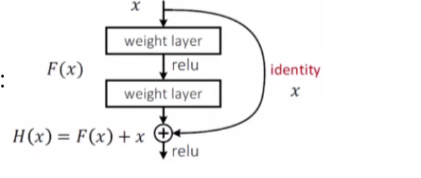

## 数据预处理

In [46]:
import os, shutil
# 下载的kaggle数据集路径
original_dataset_dir = 'D:\PythonDataAys\猫狗识别（resnet）\data' 
# 新的小数据集放置路径
base_dir = 'D:\PythonDataAys\猫狗识别（resnet）\cats_and_dogs_small' 
os.mkdir(base_dir)
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
     src = os.path.join(original_dataset_dir, fname)
     dst = os.path.join(test_cats_dir, fname)
     shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))



total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


## 做数据增强

In [47]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator=train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(150,150),
    class_mode='binary',
    batch_size=20
)

#验证样本生成器
validation_datagen=ImageDataGenerator(rescale=1./255)
validation_generator=train_datagen.flow_from_directory(
    directory=validation_dir,
    target_size=(150,150),
    class_mode='binary',
    batch_size=20
)

#测试样本生成器
test_datagen=ImageDataGenerator(rescale=1./255)
test_generator=train_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(150,150),
    class_mode='binary',
    batch_size=20
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## 定义预训练网络模型(resnent)

In [48]:
from torchvision import transforms, models, datasets
model_name = 'resnet'  #可选的比较多 ['resnet', 'alexnet', 'vgg', 'squeezenet', 'densenet', 'inception']
#是否用人家训练好的特征来做
feature_extract = True #都用人家特征，咱先不更新

In [49]:
import torch
from torch import nn
import torch.optim as optim
import torchvision
# 是否用GPU训练
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

CUDA is not available.  Training on CPU ...


In [50]:
model_ft = models.resnet18()#18层的能快点，条件好点的也可以选152
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 冻结卷积层

In [51]:
def set_parameter_requires_grad(model, feature_extracting):  # 冻住哪些层
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [86]:
import torch.nn as nn
import torchvision.models as models

def initialize_model(num_classes, feature_extract, use_pretrained=True):
    model_ft = models.resnet18(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    
    # 修改输出层为二分类
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)  # 将输出层的节点数设置为num_classes

    # 不再需要手动初始化权重和偏置，nn.Linear 会自动进行初始化
    # 初始化权重和偏置
    
    input_size = 224  # 输入大小根据 ResNet 的默认输入大小来
    
    return model_ft, input_size




### 初始化模型

In [88]:
model_ft, input_size = initialize_model(2, feature_extract)
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 设置哪些层需要训练

In [71]:
#GPU还是CPU计算
model_ft = model_ft.to(device)

# 模型保存，名字自己起
filename='checkpoint.pth'

# 是否训练所有层
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


# 看一下微调后的resnet模型

In [72]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 可以看到最后分类为2 微调成功

# 配置优化器设置

In [73]:
# 优化器设置
optimizer_ft = optim.Adam(params_to_update, lr=1e-2)#要训练啥参数，你来定 adam优化器 学习率lr
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)#学习率每7个epoch 衰减成原来的1/10
#最后一层已经LogSoftmax(）了  所以不能再用交叉熵来计算了
criterion = nn.CrossEntropyLoss() #利用交叉商损失标准函数来做
#criterion = nn.NULLose()

# 定义训练模块

In [74]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25,filename='best.pt'):
    #咱们要算时间的
    since = time.time()
    #也要记录最好的那一次
    best_acc = 0
    #模型也得放到你的CPU或者GPU
    model.to(device)
    #训练过程中打印一堆损失和指标
    val_acc_history = []
    train_acc_history = []
    train_losses = []
    valid_losses = []
    #学习率
    LRs = [optimizer.param_groups[0]['lr']]
    #拿到最好的那次模型，后续会变的，先初始化
    best_model_wts = copy.deepcopy(model.state_dict())
    #一个个epoch来遍历
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 训练和验证
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # 训练
            else:
                model.eval()   # 验证

            running_loss = 0.0
            running_corrects = 0

            # 把数据都取个遍
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)#放到你的CPU或GPU
                labels = labels.to(device)

                # 清零
                optimizer.zero_grad()
                # 只有训练的时候计算和更新梯度
                outputs = model(inputs) #拿到计算结果
                loss = criterion(outputs, labels) #在损失函数种计算损失
                _, preds = torch.max(outputs, 1) #把结果种最大的索引保存下来
                # 训练阶段更新权重
                if phase == 'train':
                    loss.backward()    #训练时才做梯度下降和更新参数
                    optimizer.step()

                # 计算损失
                running_loss += loss.item() * inputs.size(0)#0表示batch那个维度
                running_corrects += torch.sum(preds == labels.data)#预测结果最大的和真实值是否一致
                
            
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)#算平均
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            time_elapsed = time.time() - since#一个epoch我浪费了多少时间
            print('Time elapsed {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            

            # 得到最好那次的模型 保存模型
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) #把当前最好的模型的权重参数都复制过来
                state = {
                  'state_dict': model.state_dict(),#字典里key就是各层的名字，值就是训练好的权重
                  'best_acc': best_acc,
                  'optimizer' : optimizer.state_dict(),
                }
                torch.save(state, filename) #把这些状态值保存的文件种 方便下次读
            if phase == 'validation':
                val_acc_history.append(epoch_acc)
                valid_losses.append(epoch_loss)
                #scheduler.step(epoch_loss)#学习率衰减
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_losses.append(epoch_loss)
        
        print('Optimizer learning rate : {:.7f}'.format(optimizer.param_groups[0]['lr']))
        LRs.append(optimizer.param_groups[0]['lr'])
        print()
        scheduler.step()#学习率衰减

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 训练完后用最好的一次当做模型最终的结果,等着一会测试
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history, valid_losses, train_losses, LRs 

### 开始训练！

- 我们最开始只训练了输出层

In [75]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder

# 定义数据集类
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.dataset = ImageFolder(self.data_dir, transform=self.transform)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

# 定义数据预处理
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # 调整图像大小
    transforms.ToTensor(),           # 将图像转换为张量
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化图像
])

# 定义数据集路径
train_dir = r'D:\PythonDataAys\猫狗识别（resnet）\cats_and_dogs_small\train'
validation_dir = r'D:\PythonDataAys\猫狗识别（resnet）\cats_and_dogs_small\validation'


# 创建训练集和验证集对象
train_dataset = CustomDataset(train_dir, transform=data_transforms)
validation_dataset = CustomDataset(validation_dir, transform=data_transforms)

# 定义批次大小
batch_size = 20

# 定义数据加载器
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

# 将数据加载器存储在字典中
dataloaders = {'train': train_loader, 'validation': validation_loader}

# 在调用 train_model 函数之前，请确保 dataloaders 被正确定义
model_ft, val_acc_history, train_acc_history, valid_losses, train_losses, LRs = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=20)


Epoch 0/19
----------
Time elapsed 0m 44s
train Loss: 0.3053 Acc: 0.9045
Time elapsed 1m 3s
validation Loss: 0.1043 Acc: 0.9660
Optimizer learning rate : 0.0100000

Epoch 1/19
----------
Time elapsed 1m 47s
train Loss: 0.1550 Acc: 0.9525
Time elapsed 2m 7s
validation Loss: 0.0812 Acc: 0.9750
Optimizer learning rate : 0.0100000

Epoch 2/19
----------
Time elapsed 2m 53s
train Loss: 0.1954 Acc: 0.9455
Time elapsed 3m 14s
validation Loss: 0.1054 Acc: 0.9700
Optimizer learning rate : 0.0100000

Epoch 3/19
----------
Time elapsed 4m 4s
train Loss: 0.1115 Acc: 0.9655
Time elapsed 4m 24s
validation Loss: 0.1297 Acc: 0.9620
Optimizer learning rate : 0.0100000

Epoch 4/19
----------
Time elapsed 5m 11s
train Loss: 0.2402 Acc: 0.9405
Time elapsed 5m 32s
validation Loss: 0.0952 Acc: 0.9670
Optimizer learning rate : 0.0100000

Epoch 5/19
----------
Time elapsed 6m 22s
train Loss: 0.2345 Acc: 0.9505
Time elapsed 6m 44s
validation Loss: 0.1025 Acc: 0.9700
Optimizer learning rate : 0.0100000

Epoch 6

### 可以看到我们最好的验证率高达97.4%

### 再继续训练所有层

In [76]:
for param in model_ft.parameters():
    param.requires_grad = True

# 再继续训练所有的参数，学习率调小一点
optimizer = optim.Adam(model_ft.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# 损失函数
criterion = nn.CrossEntropyLoss()

In [77]:
# 加载之前训练好的权重参数

checkpoint = torch.load('best.pt')
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

### 开始训练剩下的层

In [78]:
model_ft, val_acc_history, train_acc_history, valid_losses, train_losses, LRs  = train_model(model_ft,
                                                                                             dataloaders, 
                                                                                             criterion,
                                                                                             optimizer, 
                                                                                             num_epochs=10,)

Epoch 0/9
----------
Time elapsed 1m 48s
train Loss: 0.7442 Acc: 0.8340
Time elapsed 2m 9s
validation Loss: 0.3720 Acc: 0.8500
Optimizer learning rate : 0.0010000

Epoch 1/9
----------
Time elapsed 4m 1s
train Loss: 0.1482 Acc: 0.9340
Time elapsed 4m 21s
validation Loss: 0.3009 Acc: 0.9080
Optimizer learning rate : 0.0010000

Epoch 2/9
----------
Time elapsed 6m 12s
train Loss: 0.1076 Acc: 0.9635
Time elapsed 6m 31s
validation Loss: 0.1425 Acc: 0.9380
Optimizer learning rate : 0.0010000

Epoch 3/9
----------
Time elapsed 8m 19s
train Loss: 0.0887 Acc: 0.9700
Time elapsed 8m 38s
validation Loss: 0.2864 Acc: 0.8810
Optimizer learning rate : 0.0010000

Epoch 4/9
----------
Time elapsed 10m 27s
train Loss: 0.0855 Acc: 0.9710
Time elapsed 10m 48s
validation Loss: 0.7552 Acc: 0.7810
Optimizer learning rate : 0.0010000

Epoch 5/9
----------
Time elapsed 12m 37s
train Loss: 0.0963 Acc: 0.9675
Time elapsed 12m 57s
validation Loss: 0.1267 Acc: 0.9510
Optimizer learning rate : 0.0010000

Epoch 6/

### 加载训练好的模型

In [90]:

model_ft = model_ft.to(device)

# 保存文件的名字
filename='best.pt'

# 加载模型
checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'。]，)

<All keys matched successfully>

### 测试数据预处理
- 测试数据处理方法需要跟训练时一直才可以
- crop操作的目的是保证输入的大小是一致的
- 标准化操作也是必须的，用跟训练数据相同的mean和std,但是需要注意一点训练数据是在0-1上进行标准化，所以测试数据也需要先归一化
- 最后一点，PyTorch中颜色通道是第一个维度，跟很多工具包都不一样，需要转换


In [91]:
# 得到一个batch的测试数据
dataiter = iter(dataloaders['validation'])
images, labels = next(dataiter)  # 修改此行代码

model_ft.eval()

if train_on_gpu:
    output = model_ft(images.cuda())
else:
    output = model_ft(images)


### output表示对一个batch中每一个数据得到其属于各个类别的可能性

In [92]:
output.shape

torch.Size([20, 2])

### 我们需要的是得到概率最大的那个

In [94]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
_, preds_tensor = torch.max(output, 1)

preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
      dtype=int64)

### 展示预测结果

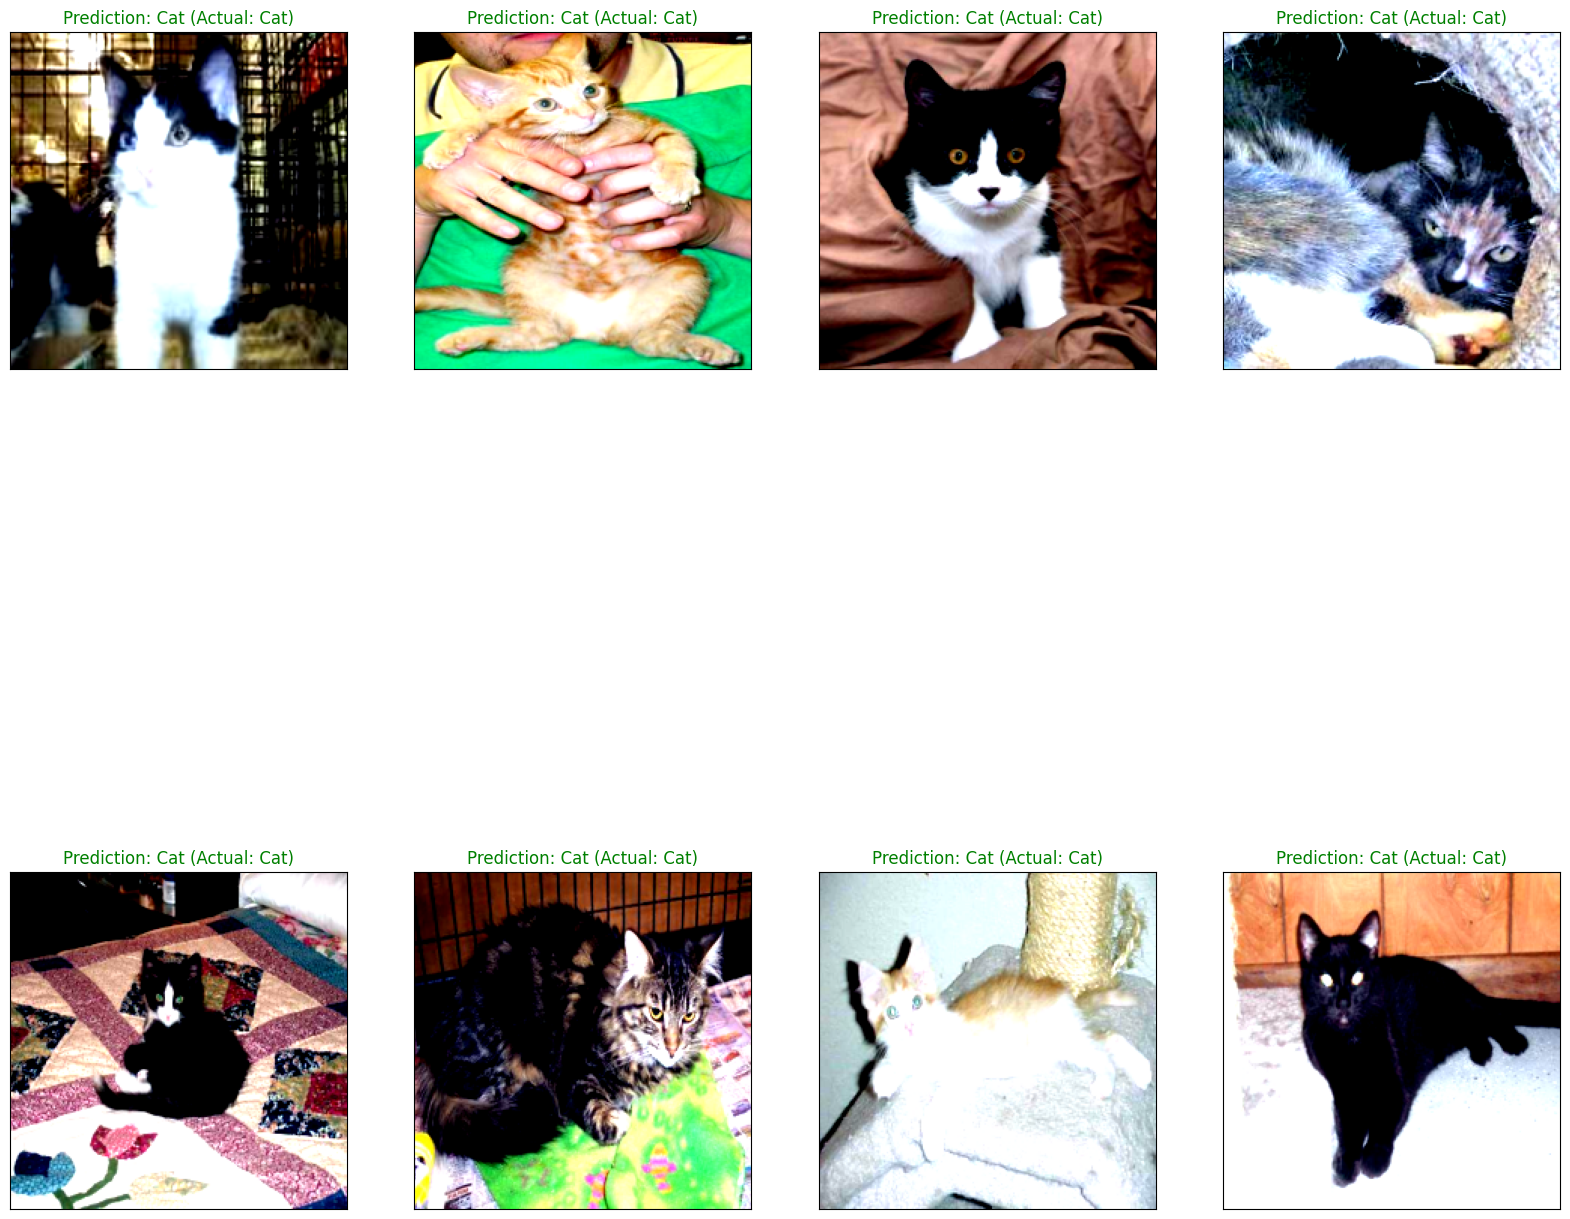

In [97]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision import transforms

# 定义转换函数
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()  # 将张量从 GPU 转移到 CPU，并将其转换为 NumPy 数组
    image = image.transpose(1, 2, 0)  # 将通道维度调整到最后一个维度
    # 由于您的图像可能已经标准化，因此您可能需要执行逆标准化操作
    # 如果您的图像已经在 [0, 1] 范围内，则可以跳过此步骤
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)  # 将像素值截断到 [0, 1] 范围内
    return image

# 使用转换函数将 PyTorch 张量转换为图像
transformed_images = [im_convert(image) for image in images]

# 定义图形大小和布局
fig = plt.figure(figsize=(20, 20))
columns = 4
rows = 2

# 循环遍历每个图像进行展示
for idx in range(columns * rows):
    ax = fig.add_subplot(rows, columns, idx + 1, xticks=[], yticks=[])
    plt.imshow(transformed_images[idx])  # 使用转换后的图像进行显示
    # 根据预测结果设置标题颜色
    color = "green" if preds[idx] == labels[idx].item() else "red"
    # 根据预测结果设置标题
    prediction = "Dog" if preds[idx] == 1 else "Cat"
    actual = "Dog" if labels[idx].item() == 1 else "Cat"
    ax.set_title("Prediction: {} (Actual: {})".format(prediction, actual), color=color)

plt.show()


### 可以看到我们的预测结果都是绿色的正确

### 现在我们想测试一下自己选择的卡通图片来验证

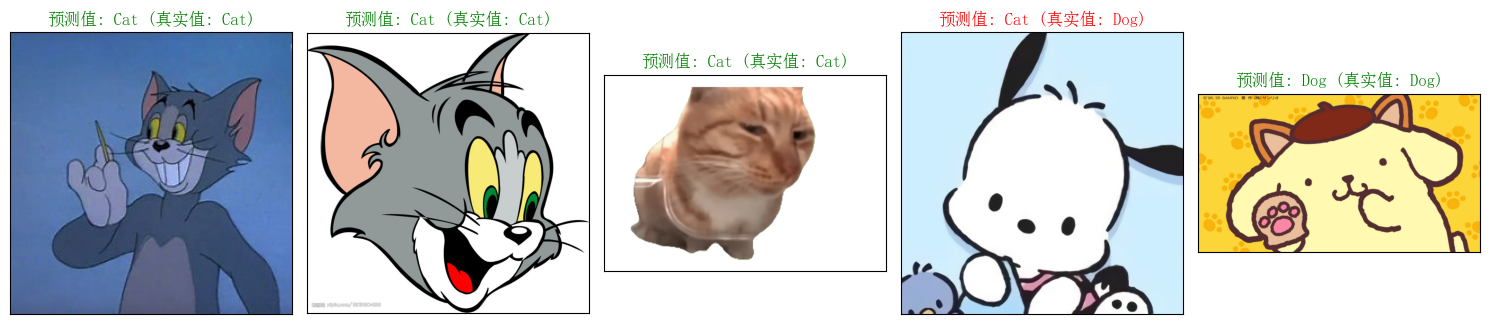

In [115]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
from torchvision import transforms


# 定义预处理转换
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 定义图像文件名列表和对应的真实标签
image_files = [r'D:\PythonDataAys\猫狗识别（resnet）\cats_and_dogs_small\test\cats\cat.2000.jpg',
               r'D:\PythonDataAys\猫狗识别（resnet）\cats_and_dogs_small\test\cats\cat.2001.jpg',
               r'D:\PythonDataAys\猫狗识别（resnet）\cats_and_dogs_small\test\cats\cat.2002.jpg',
               r'D:\PythonDataAys\猫狗识别（resnet）\cats_and_dogs_small\test\dogs\dog.2000.jpg',
               r'D:\PythonDataAys\猫狗识别（resnet）\cats_and_dogs_small\test\dogs\dog.2001.jpg']
true_labels = ["Cat", "Cat", "Cat",
              "Dog","Dog","Dog"]  # 根据文件名或其他方式获取真实标签

# 加载您的模型
model = model_ft

# 定义图形大小和布局
fig = plt.figure(figsize=(15, 5))
columns = len(image_files)
rows = 1
plt.rcParams['font.sans-serif'] = ['SimSun']  # 设置中文字体为宋体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
# 循环遍历每张图像进行展示和预测
for idx, image_file in enumerate(image_files):
    # 读取图像
    image = Image.open(image_file)
    # 进行预处理转换
    input_tensor = preprocess(image)
    # 添加一个批次维度
    input_tensor = input_tensor.unsqueeze(0)
    
    # 模型推理
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
        prediction = "Dog" if predicted.item() == 1 else "Cat"
    
    # 显示图像和预测结果
    ax = fig.add_subplot(rows, columns, idx + 1, xticks=[], yticks=[])
    ax.imshow(image)

    # Determine label color based on prediction correctness
    label_color = 'green' if prediction == true_labels[idx] else 'red'
    # 添加真实标签和预测标签到标题中
    ax.set_title("预测值: {} (真实值: {})".format(prediction, true_labels[idx]),color=label_color)

plt.tight_layout()
plt.show()
